In [1]:
import sys
import os
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

os.chdir('..')

from utils.meta_util import load_meta_infos, collect_by, filter_by
from utils.tensor_holders import TensorHolder
from utils.plot_util import plot, legend
from utils.np_util import step_with_end

plot_dir = Path('results')
losses_label = '$mc_estimator$ $sample_size$ sample(s)'

mnist_results = load_meta_infos(Path('results', 'vae', 'mnist'))

# Plot VAE MNIST Losses

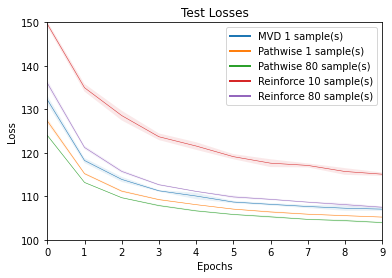

In [2]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

step_size = 1
max_len = 0
for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlim(0, max_len)
plt.ylim(100, 150)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Test Losses')
plt.savefig(plot_dir / f'vae_mnist_test_losses.pdf')
plt.show()

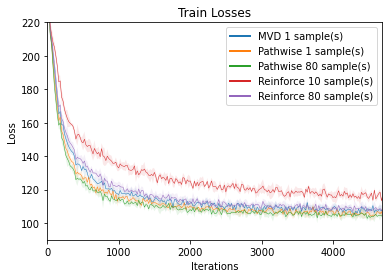

In [3]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss')))
test_losses.default_factory = None

step_size = 20
max_len = 0
for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.ylim(90, 220)
plt.xlim(0, max_len)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Train Losses')
plt.savefig(plot_dir / f'vae_mnist_train_losses.pdf')
plt.show()

# Plot VAE MNIST Train Losses by process time

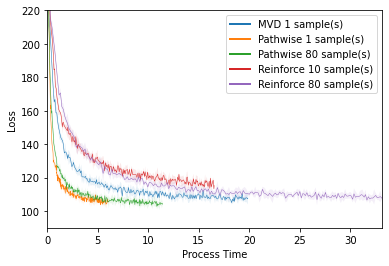

In [4]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss'), TensorHolder.load(meta['results_dir'], 'iteration_times')))
test_losses.default_factory = None

step_size = 20
max_len = 0
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    timestamps = []
    for meta, loss, timestamp in run:
        losses.append(loss.data.numpy().flatten())
        timestamps.append(timestamp.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    _, timestamps = step_with_end(np.array(timestamps).mean(axis=0), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta, xspace=timestamps)
    max_len = max(max_len, timestamps[-1])

legend()
plt.xlabel('Process Time')
plt.ylabel('Loss')
plt.ylim(90, 220)
plt.xlim(0, max_len)
plt.savefig(plot_dir / f'vae_mnist_train_timed_losses_until_end.pdf')
plt.show()

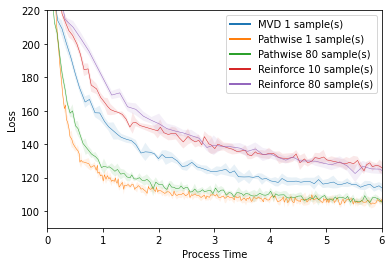

In [5]:
test_losses = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss'), TensorHolder.load(meta['results_dir'], 'iteration_times')))
test_losses.default_factory = None

step_size = 20
shortest_run = float('inf')
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    timestamps = []
    for meta, loss, timestamp in run:
        losses.append(loss.data.numpy().flatten())
        timestamps.append(timestamp.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    _, timestamps = step_with_end(np.array(timestamps).mean(axis=0), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), losses_label, meta, xspace=timestamps)
    shortest_run = min(shortest_run, timestamps[-1])

legend()
plt.xlabel('Process Time')
plt.ylabel('Loss')
plt.ylim(90, 220)
if test_losses.values():
    plt.xlim(0, shortest_run)
plt.savefig(plot_dir / f'vae_mnist_train_timed_losses.pdf')
plt.show()

# Variances

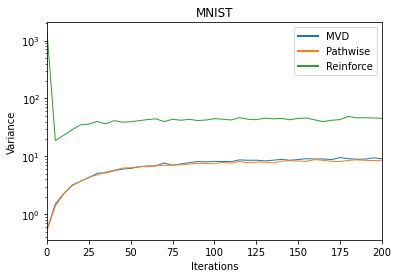

In [2]:
estimator_stds = defaultdict(list)
for k, v in collect_by(mnist_results, 'mc_estimator').items():
    for meta in v:
        try:
            estimator_stds[k].append((meta, TensorHolder.load(meta['results_dir'], 'estimator_stds')))
        except FileNotFoundError:
            continue
estimator_stds.default_factory = None

step_size = 5
max_len = 0
for run in estimator_stds.values():
    meta, _ = run[0]
    stds = []
    for meta, std in run:
        stds.append(std.data.numpy().flatten())
    indices, stds = step_with_end(np.array(stds), step_size)
    vars_ = (stds**2).mean(axis=0)
    plot(vars_, np.zeros_like(vars_), '$mc_estimator$', meta, xspace=indices, linewidth=1)
    max_len = max(max_len, indices[-1])

legend()
plt.yscale('log')
plt.ylabel('Variance')
plt.xlabel('Iterations')
plt.title('MNIST')
plt.xlim(0, 200)
plt.savefig(plot_dir / f'mnist_variances.pdf')
plt.show()

# Convex combination of MV and SF estimators

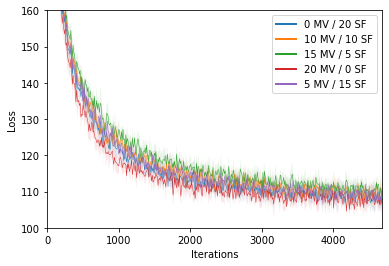

In [9]:
convex_results = load_meta_infos(Path('results', 'vae', 'mnist_mvsf'))

train_losses = defaultdict(list)
for k, v in collect_by(convex_results, 'mv_dims').items():
    for meta in v:
        train_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss')))
train_losses.default_factory = None

max_len = 0
step_size = 10
for run in train_losses.values():
    meta = run[0][0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    mv_dims = meta['mv_dims']
    label = f'{mv_dims} MV / {20-mv_dims} SF'
    plot(losses.mean(axis=0), losses.std(axis=0), label, meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(100, 160)
plt.xlim(0, max_len-1)
plt.savefig(plot_dir / f'vae_mnist_mvsf_train_losses.pdf')
plt.show()

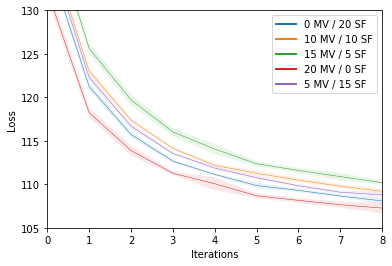

In [10]:
test_losses = defaultdict(list)
for k, v in collect_by(convex_results, 'mv_dims').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

max_len = 0
step_size = 1
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    mv_dims = meta['mv_dims']
    label = f'{mv_dims} MV / {20-mv_dims} SF'
    plot(losses.mean(axis=0), losses.std(axis=0), label, meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(105, 130)
plt.xlim(0, max_len-1)
plt.savefig(plot_dir / f'vae_mnist_mvsf_test_losses.pdf')
plt.show()

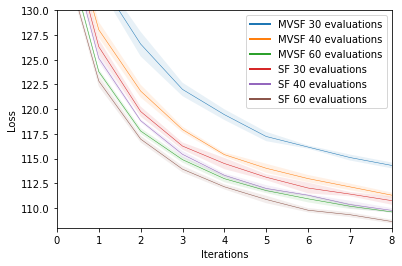

In [48]:
convex_varied_samples_results = load_meta_infos(Path('results', 'vae', 'mnist_mvsf_vary_sample_size'))

test_losses = defaultdict(list)
for k, v in collect_by(convex_varied_samples_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

max_len = 0
step_size = 1
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    if meta['mc_estimator'] == 'MVSF':
        evaluations = meta['sample_size'] + 20
    else:
        evaluations = meta['sample_size']
    label = f'{meta["mc_estimator"]} {evaluations} evaluations'
    plot(losses.mean(axis=0), losses.std(axis=0), label, meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(108, 130)
plt.xlim(0, max_len-1)
plt.savefig(plot_dir / f'vae_mnist_varied_samples_mvsf_test_losses.pdf')
plt.show()

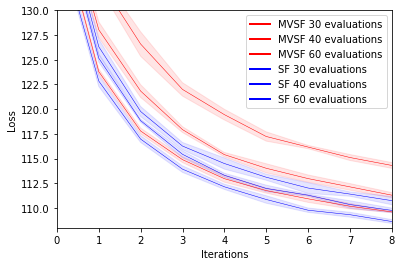

In [49]:
convex_varied_samples_results = load_meta_infos(Path('results', 'vae', 'mnist_mvsf_vary_sample_size'))

test_losses = defaultdict(list)
for k, v in collect_by(convex_varied_samples_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

max_len = 0
step_size = 1
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    if meta['mc_estimator'] == 'MVSF':
        evaluations = meta['sample_size'] + 20
        color = 'red'
    else:
        evaluations = meta['sample_size']
        color = 'blue'
    label = f'{meta["mc_estimator"]} {evaluations} evaluations'
    plot(losses.mean(axis=0), losses.std(axis=0), label, meta, xspace=indices, color=color)
    max_len = max(max_len, indices[-1])

legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(108, 130)
plt.xlim(0, max_len-1)
plt.savefig(plot_dir / f'vae_mnist_varied_samples_mvsf_test_losses_red_blue.pdf')
plt.show()

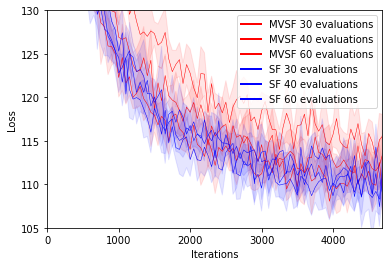

In [29]:
test_losses = defaultdict(list)
for k, v in collect_by(convex_varied_samples_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'train_loss')))
test_losses.default_factory = None

max_len = 0
step_size = 50
for run in test_losses.values():
    meta = run[0][0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    if meta['mc_estimator'] == 'MVSF':
        evaluations = meta['sample_size'] + 20
        color = 'red'
    else:
        evaluations = meta['sample_size']
        color = 'blue'
    label = f'{meta["mc_estimator"]} {evaluations} evaluations'
    plot(losses.mean(axis=0), losses.std(axis=0), label, meta, xspace=indices, color=color)
    max_len = max(max_len, indices[-1])

legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(105, 130)
plt.xlim(0, max_len-1)
plt.savefig(plot_dir / f'vae_mnist_varied_samples_mvsf_train_losses.pdf')
plt.show()

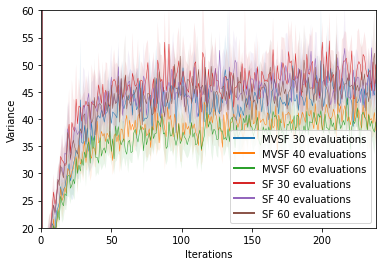

In [46]:
variances = defaultdict(list)
for k, v in collect_by(convex_varied_samples_results, 'mc_estimator', 'sample_size').items():
    for meta in v:
        variances[k].append((meta, TensorHolder.load(meta['results_dir'], 'estimator_stds')))
variances.default_factory = None

max_len = 0
step_size = 1
for run in variances.values():
    meta = run[0][0]
    
    vars_ = []
    for _, std in run:
        vars_.append(np.square(std.data.numpy().flatten()))
    indices, vars_ = step_with_end(np.array(vars_), step_size)
    
    estimator = meta['mc_estimator']
    evaluations = meta['sample_size'] + 20 if estimator == 'MVSF' else meta['sample_size']
    label = f'{estimator} {evaluations} evaluations'
    plot(vars_.mean(axis=0), vars_.std(axis=0), label, meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.ylim(20, 60)
plt.xlim(0, max_len-1)
plt.savefig(plot_dir / f'vae_mnist_varied_samples_mvsf_vars.pdf')
plt.show()